### Problem Set 6 - Principal Component Analysis

Consider the following data generating process with n = 100 observations and p covariates. Initially set the
number of predictors p = 2 and X ∼ N p (μ, Σ). Σ is the covariance matrix with the variance on the diagonal
and small values on the off-diagonal (both values chosen by you). μ = !0 10". The (initially) true coefficients
range from β = 0.1 − 0 (you can sample values from that range or use equispaced values on that interval) and
the errors are drawn from a normal distribution ε ∼ N (0, 1).
The aim of this exercise: compare OLS, ridge regression, lasso and PCR.
a) Calculate the principal component scores as shown in the lecture. Visualize the principal components along
with the original observations.
b) Perform PCR using and and both principal components.
c) Calculate the prediction error for ridge regression, lasso and PCR using one and two principal components

# Packages

In [2]:
rm(list = ls())
library(MASS)
library(pls)
library(glmnet)
library(factoextra)
library(plsdof)
library(tidyverse)
library(patchwork)
library(hrbrthemes)
library(viridis)
library(Matrix)

Warning message:
"package 'MASS' was built under R version 4.0.5"
Warning message:
"package 'pls' was built under R version 4.0.5"

Attaching package: 'pls'


The following object is masked from 'package:stats':

    loadings


Warning message:
"package 'glmnet' was built under R version 4.0.5"
Loading required package: Matrix

Loaded glmnet 4.1-4

Warning message:
"package 'factoextra' was built under R version 4.0.5"
Loading required package: ggplot2

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Warning message:
"package 'plsdof' was built under R version 4.0.5"

Attaching package: 'plsdof'


The following object is masked from 'package:pls':

    pcr


Warning message:
"package 'tidyverse' was built under R version 4.0.5"
-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v tibble  3.1.6     v dplyr   1.0.8
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1
v purrr   0.3.4     

Warning me

### Data Generating Process

In [11]:

dgp <- function(N, p, Mu, Sigma, beta_true){
  # Data Generating Process
  #     Inputs:
  #            N (Int): Number of observations
  #            p (Int): Number of covariates
  #            Mu (Seq): Mean of covariates
  #            Sigma (Matrix): Var-Cov-matrix
  #            beta_true (seq): true beta vector
  #     Output:
  #            data (data.frame): data
  eps <- rnorm(n = N, mean=0, sd= 1)
  mu <- seq(Mu[1], Mu[2], length.out  = p)
  X <- mvrnorm(N, mu, Sigma)
  Y   <- X %*% beta_true + eps
  data <- data.frame("Y"= Y, "x"=X)
  
  colnames(data) <- c("Y", paste("X", 1:p, sep="_"))
  rownames(data) <- 1:N
  return(data)
}

### Function for calculating Principal Components as shown in the Lecture

In [3]:
PCA_lecture <- function(N, p, Mu, Sigma, beta_true){
  # Computes Principal Components as shown in the Lecture and checks whether eigenvalues are correctly scaled
  #     Inputs:
  #            N (Int): Number of observations
  #            p (Int): Number of covariates
  #            Mu (Seq): Mean of covariates
  #            Sigma (Matrix): Var-Cov-matrix
  #            beta_true (seq): true beta vector
  #     Output:
  #            fin_data (data.frame): Principal Component Scores
  data <- dgp(N, p, Mu, Sigma, beta_true)
  demeaned_X <- data[,-1]-colMeans(data[,-1])
  vcov <- cov(demeaned_X)
  eigenvalues <- eigen(vcov)$values
  eigenvectors <- eigen(vcov)$vectors
  
  feature_vector <- eigenvectors
  fin_data <- t(feature_vector)%*%t(demeaned_X)
  
  
  if(sqrt(eigenvectors[1,1]^2 +eigenvectors[2,1]^2) == 1 & sqrt(eigenvectors[1,2]^2 +eigenvectors[2,2]^2) == 1)
    print("Eigenvalues are correctly scaled") 
  return(t(fin_data))
}

#### a) Calculate the principal component scores as shown in the lecture. Visualize the principal components along with the original observations


$Z_1$ $=$ $\phi_{1 1}$ x $(x1 - mean(x1))$ + $\phi_{2 1}$ x $(x2 - mean(x2))$

where $\phi_{1 1}$ and $\phi_{2 1}$ are the Principal Component Loadings.

In [4]:
# Calculating PCA Scores
PCA_Scores <- PCA_lecture(N=100, p=2, Mu= c(0,10), Sigma=cbind(c(1, 0.1), c(0.1, 2)), beta_true=seq(from = 0.1, to = 0.5, length.out = 2))

In [5]:
head(PCA_Scores,5)

1,9.054703,7.231693
2,-5.657078,9.451597
3,7.668654,7.589431
4,-5.115148,6.923448
5,6.384482,8.433314


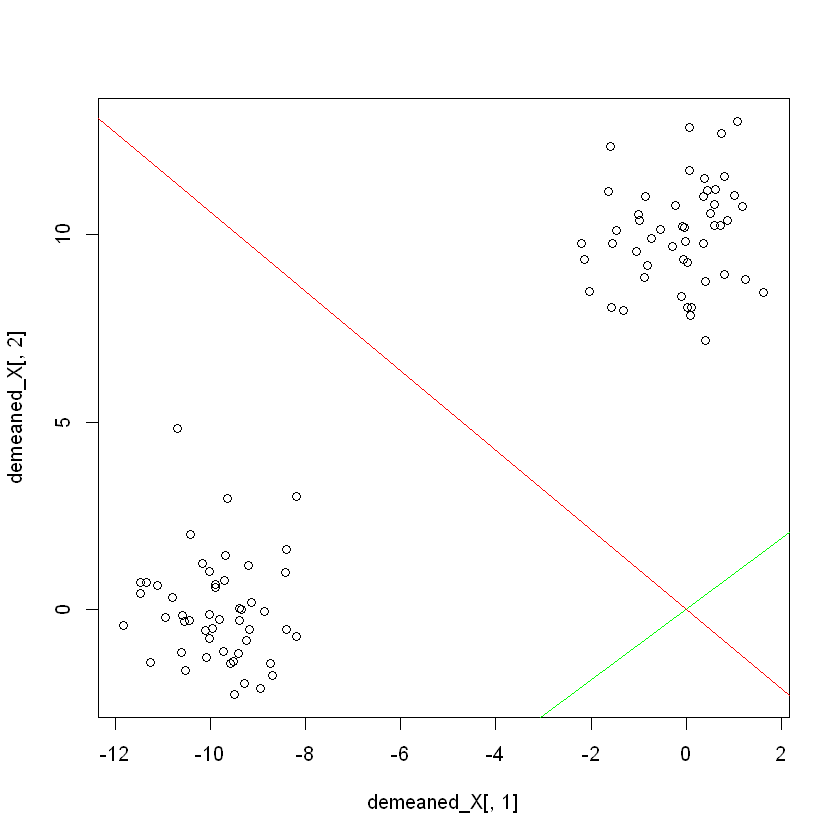

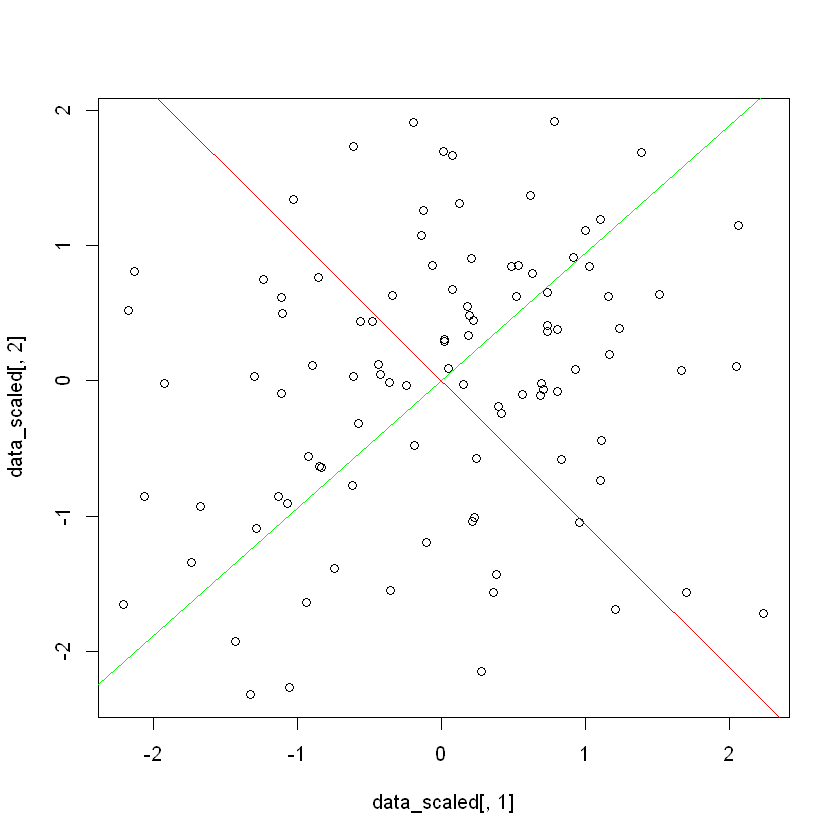

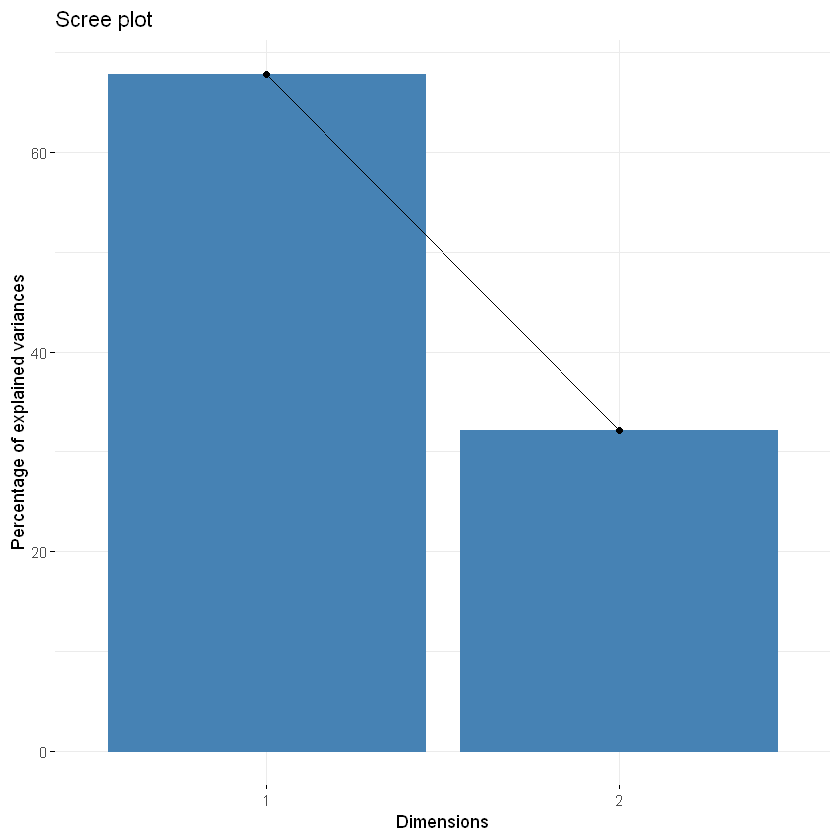

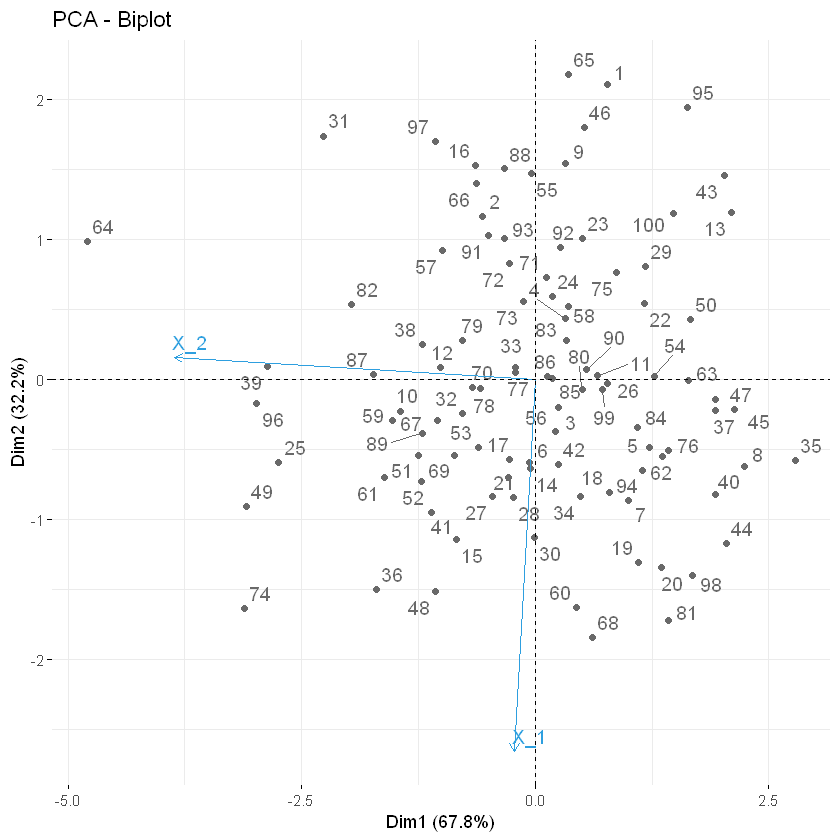

In [12]:
set.seed(123)
data <- dgp(N=100, p=2, Mu= c(0,10), Sigma=cbind(c(1, 0.1), c(0.1, 2)), beta_true=seq(from = 0.1, to = 0.5, length.out = 2))

data_scaled <- scale(data)
  demeaned_X <- data[,-1]-colMeans(data[,-1])
  
  # compute eigenvalues/vectors from data
  vcov <- cov(demeaned_X)
  eigenvalues <- eigen(vcov)$values
  eigenvectors <- eigen(vcov)$vectors
  
  ##plotting demeaned Xs 
  p.plot <- plot(demeaned_X[,1], demeaned_X[,2])
  abline(a=0,b=(eigenvectors[1,1] /eigenvectors[2,1]),col="green")
  abline(a=0,b=(eigenvectors[1,2] /eigenvectors[2,2]),col="red")
  p1 <- p.plot
  
  
  feature_vector <- eigenvectors
  fin_data <- t(feature_vector)%*%t(demeaned_X)
  
  ##plotting scaled Xs
  p.plot <- plot(data_scaled[,1], data_scaled[,2])
  abline(a=0,b=(eigenvectors[1,1] /eigenvectors[2,1]),col="green")
  abline(a=0,b=(eigenvectors[1,2] /eigenvectors[2,2]),col="red")
  p2 <- p.plot
  
covariates <- data[,-1]
pc <- prcomp(covariates, scale = FALSE)
# Returns the PC as well as the standard deviations of the principal components 
# (i.e., the square roots of the eigenvalues of the covariance/correlation matrix).

# plotting the Eigenvalues
fviz_eig(pc)
fviz_pca_biplot(pc, repel = TRUE,
                col.var = "#2E9FDF", # Variables color
                col.ind = "#696969"  # Individuals color
                );

#### b) Perform PCR using and and both principal components.

As shown in the book we use the pcr function of the pls package. It returns the percentage of total variance in the predictors and the response explained by each number of components.

Setting Validation to "CV" computes the 10-fold Cross-Validation Error for each number of components (Seen under VALIDATION: RMSEP)

Data: 	X dimension: 100 2 
	Y dimension: 100 1
Fit method: svdpc
Number of components considered: 2

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps
CV           1.131   1.0083   0.9299
adjCV        1.131   0.9795   0.9283

TRAINING: % variance explained
   1 comps  2 comps
X    52.23    100.0
Y    28.77     35.4


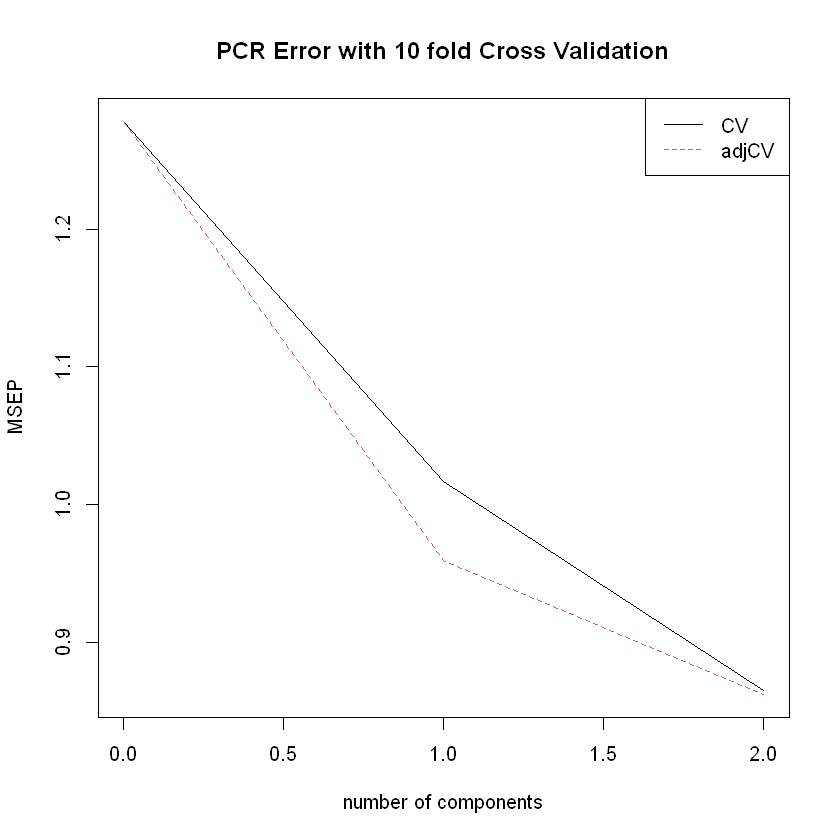

In [7]:
# Generating Data
## using pcr
pcr_fit_CV <- pls::pcr(Y~., data = data, scale = TRUE, validation = "CV")
validationplot(pcr_fit_CV ,val.type="MSEP", legendpos = "topright", main = "PCR Error with 10 fold Cross Validation")
summary(pcr_fit_CV)

#### c) Calculate the prediction error for ridge regression, lasso and PCR using one and two principal components

In [3]:
compute_MSE <- function(data , part = 1){
# Splits data into test and training sets and computes MSEs for different estimators.
#       Inputs:
#            data: generated dataset
#            part: specification argument we need different setup for part 2 with more predictors
#       Output:
#            MSES: List of MSES + in part 2 optimal number of components and tuning parameters
#
    # Split up into test and training data
    train <- sample(nrow(data), nrow(data)/2) # randomly select half of the indices which then form the training dataset
    y_test <- data[-train, 1] # true y in test data
    x_test <- data.matrix(data[-train,-1])
    #Ridge
    #Fit Ridge using optimal lambda (cv.glmnet calculates optimal lambda using 10-fold cross-validation) and calculate MSE
    cv.ridge   <- cv.glmnet(data.matrix(data[train,-1]), data[train,1], alpha = 0) # doesnt work for dataframe
    cv.ridge.pred <- predict(cv.ridge, newx = x_test, s = cv.ridge$lambda.min)
    cv.ridge.mse <- mean((cv.ridge.pred - y_test)**2)
    cv.ridge.lambda <- cv.ridge$lambda.min
    #Lasso
    #Same for Lasso
    cv.lasso   <- cv.glmnet(data.matrix(data[train,-1]), data[train,1], alpha = 1)
    cv.lasso.pred <- predict(cv.lasso, newx = x_test, s = cv.lasso$lambda.min )
    cv.Lasso.mse <- mean((cv.lasso.pred - y_test)**2)
    cv.lasso.lambda <- cv.lasso$lambda.min
    
    ## OLS
    # OLS
    OLS_fit <- lm(Y~., data = data, subset = train)
    OLS_pred <- predict(OLS_fit, data[-train,], newx = xtest)
    MSE_OLS <- mean((OLS_pred-y_test)**2)
    

    #
    if(part == 1){
        pcr_fit <- pls::pcr(Y~., data = data, subset= train, scale = TRUE, validation = "CV")
        #predict for first component
        pcr_predict_1 <- predict(pcr_fit, x_test, ncomp = 1 )
        MSE_1_comp <- mean((pcr_predict_1-y_test)^2)
        #predict for first and second component
        pcr_predict_2 <- predict(pcr_fit, x_test, ncomp = 2 )
        MSE_2_comp <- mean((pcr_predict_2-y_test)^2)
        MSES <- cbind(MSE_OLS,cv.ridge.mse,cv.Lasso.mse,MSE_1_comp,MSE_2_comp)
        return(MSES)
    }
    else{    
        cv_pcr <- pcr.cv(X = data.matrix(data[train,-1]), y = data.matrix(data[train,1]), scale = TRUE, k = 10)
        pcr_fit <- pls::pcr(Y~., data = data[train,], scale = TRUE, validation = "CV")
        m_opt <- cv_pcr$m.opt
        pcr_pred <- predict(pcr_fit, x_test, ncomp = m_opt)
        MSE_PCR_m.opt <- mean((pcr_pred - y_test)^2)
        result  <- cbind("OLS MSE" = MSE_OLS, "Ridge MSE" = cv.ridge.mse, "Lasso MSE" = cv.Lasso.mse,
                          "PCR MSE" = MSE_PCR_m.opt, "lam_r" = cv.ridge.lambda,
                          "lam_l" = cv.lasso.lambda, "M" = m_opt)
      
      
        return(result)
        }

    }

In [62]:
set.seed(123)
compute_MSE(data,1)

MSE_OLS,cv.ridge.mse,cv.Lasso.mse,MSE_1_comp,MSE_2_comp
0.870324,0.8257442,0.8696323,0.7737202,0.870324


### Comparison.

- MSE PCR with M=2 is exactly the same as that of OLS -> OLS should yield the same predictions as PCR when using both components

- In this single Run PCR using only one component has by far the lowest MSE
- Ridge performs a little bit better than Lasso and OLS --> In theory if we have many equal sized effects Ridge should do better than Lasso

cant say too much only depends on one realization of the DGP

# Part 2: Simulation Study

#### a) Evaluate the difference in prediction performance of the four methods for p = 10 in a simulation study,choose the number of principal components using K-fold cross validation

simulation 1: 

* N = 100     (observations)
* p = 10      (Regressors)
* mu = 0 to 10      (mean of regressors) --> sequence from 0 to 10
* Sigma = 1   (covariance matrix on-diagonals are 1 (variances))
* Corr = 0    (covariancnce matrix off-diagonals are 0)
* betas = 0.1 to 0.5 (true betas) --> sequence from 0.1 to 0.5

$ \Large \Sigma = \begin{bmatrix} 1 & 0 & 0 & 0 & ... &0\\ 0 & 2 & 0 & 0 & ... & 0\\ 0 & 0 & 1 & 0 & ... & 0\\ 0 & 0 & 0 &2 & ... & 0\\
... & ... & ... & ... & ... & 0 \\ 0 & 0 & 0 & 0 & 0 & 2\end{bmatrix}$

$ \mu = \begin{bmatrix} 0 & 1.11 & 2.22 & 3.33 & ... & 10 \end{bmatrix}$

$ \beta = \begin{bmatrix} 0.1 & ... & 0.5 \end{bmatrix}$

In [15]:
set.seed(123)
sig_diag <- rep(c(1,2),5)
Sigma <- diag(sig_diag,10,10)
results <- c()

for(i in 1:500){
    data_sim <- dgp(N =100, p =10, Mu= c(0,10),Sigma=Sigma,beta_true = seq(from = 0.1, to = 0.5, length.out = 10))
      
    result <- compute_MSE(data_sim,2)
    results <- rbind(results,result)
      
      rownames(results) <- NULL
        }
  
  head(results,5)

In [10]:
Means <- c(mean(results[,1]), mean(results[,2]), mean(results[,3]), mean(results[,4]), mean(results[,7]))


Means <- data.frame(rbind(Means), row.names = c("Mean of Simulation MSE"))   #
colnames(Means) <- c("OLS", "Ridge", "Lasso", "PCR", "M")
Means


,OLS,Ridge,Lasso,PCR,M
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Mean of Simulation MSE,1.273261,1.254062,1.287937,1.324368,9.066


## Results of First Simulation:

Ridge and Lasso outperform OLS and PCR in this setting: PCR performs the worst. Ridge performs the best.

* PCR takes 9.066 components into account -> almost no dimension reduction with p=10
* Guess why Ridge performs better than Lasso: Ridge takes all predictors into account while Lasso might set some beta estimates to zero



## Part b) Propose at least 2 changes to the dgp which could make Lasso perform worse than PCR/Ridge

## Ridge Regression

* When there are **many correlated variables** in a linear regression model,
their coefficients can become poorly determined and exhibit high variance.

* Ridge regression’s advantage over least squares is rooted in the **bias-variance trade-off**. As λ increases, the flexibility of the ridge regression fit decreases, leading to decreased variance but increased bias. (Recall that the test mean squared error **(MSE)** is a function of the **variance plus the squared bias**.)

* ridge regression works best in situations where the least squares estimates have high variance. (high variance means that a small change in the training data can cause a large change in the least squares coefficient estimates)

* disadvantage: ridge regression will include all p predictors in the final model

## Lasso Regression

* forcing some of the coefficient estimates to be **exactly equal to zero** when the tuning parameter λ is sufficiently large. Hence, much like best subset selection, the lasso performs **variable selection**. lasso yields **sparse models** —that is, sparse models that involve only a subset of the variables.

* also **bias-variance trade-off:** as λ increases, the variance decreases and the bias increases.

* Lasso outperforms Ridge **if only a few regressors predict Y**! lasso to perform better in a setting where a relatively small number of predictors have substantial coefficients, and the remaining predictors have coefficients that are very small or that equal zero.

## Principal Component Regression

* PCR has a theoretical Advantage over other Methods if few components explain a lot of the variation in the data (predictors and response):
    * that is the case when the relevant predictors are correlated 
    * PCA then summarizes the variation in few components

In [4]:
## First set up a new Data-generating process which allows us to adapt some betas and variance covariance matrix

dgp2 <- function(N, Mu, Sigma, beta_grid, pshare, sparsity, correlated = TRUE,corr_par){
# Function which generates datasets with specified parameters for part2
#
#      Inputs:
#           N (int): Observations
#           Mu (seq): minimum and maximum value for predictor mean
#           Sigma(float): on-diagonal value for var-cov matrix   
#           beta_grid(seq): min and max value of beta for uniform distribution
#           p_share(float): number of predictors generated as a fraction of N
#           sparsity(float): sparsity parameter: share of predictors which true betas are set to zero
#           correlated(Bool): optional argument. If FALSE diagonal entries of var-cov matrix will be set to 0 (default: TRUE)
#           corr_par(float): correlation between predictors
#      Output:
#            data(dataframe): Dataset containing (N*p_share) + 1 x N observations  
#
  p <- round(pshare * N)
  beta_true <- runif(p,beta_grid[1],beta_grid[2])
  eps <- rnorm(n = N, mean=0, sd= 1)
  mu <- seq(Mu[1], Mu[2], length.out  = p) #runif(p,Mu[1],Mu[2]) -->
  
  spar_grid <- seq(1,p)
  sp <- sample(spar_grid, round(sparsity*p))
  beta_true[c(sp)] <- 0
  
  compare_vec <- seq(1:p)
  bool_vec <- compare_vec[! compare_vec %in% sp]
  
  if(correlated == TRUE){
    Sig <- diag(1,p,p)
    relevant_predictors <- 1:length(bool_vec)
    for (pred in relevant_predictors){
      Sig[relevant_predictors[pred],relevant_predictors[-pred]] <- corr_par
    }
  }else{
    Sig <- diag(Sigma,p,p)
  }
  
  X <- mvrnorm(N, mu, Sig)
  Y   <- X %*% beta_true + eps
  data <- data.frame("Y"= Y, "x"=X)
  
  colnames(data) <- c("Y", paste("X", 1:p, sep="_"))
  rownames(data) <- 1:N
  return(data)  
}

### Simulation function that returns MSES for different Methods

sim <- function(N, Mu, Sigma, beta_grid, pshare, sparsity, reps, correlated = TRUE,corr_par){
#  Function which executes simulation for the specified parameters and returns the MSES of the different
#  Methods as well as MSE-boxplots and plots for the CV-optimal number of components in each run
#      Inputs:
#           N (int): Observations
#           Mu (seq): minimum and maximum value for predictor mean
#           Sigma(float): on-diagonal value for var-cov matrix   
#           beta_grid(seq): min and max value of beta for uniform distribution
#           p_share(float): number of predictors generated as a fraction of N
#           sparsity(float): sparsity parameter: share of predictors which true betas are set to zero
#           correlated(Bool): optional argument. If FALSE diagonal entries of var-cov matrix will be set to 0 (default: TRUE)
#           corr_par(float): correlation between predictors
#      Output:
#            sim(list): List containing the Mean Squared Errors and optimal parameters for the different methods and   
#                       MSE-boxplot and plot for the CV-optimal number of component
  results <- c()
  for(i in 1:reps){
    data_sim <- dgp2(N, Mu, Sigma, beta_grid, pshare, sparsity, correlated = TRUE,corr_par)
    result <- compute_MSE(data_sim,2)      
    results <- rbind(results,result)
  }
  
  Means <- c(colMeans(results))
  Means <- data.frame(rbind(Means), row.names = c("Mean of Simulation MSE"))   #
  colnames(Means) <- c("OLS", "Ridge", "Lasso", "PCR", "Lambda_Ridge","Lambda_Lasso","M")
  
  a <- as.data.frame(results)
    colnames(a) <- c("OLS", "Ridge", "Lasso", "PCR", "Lambda Ridge", "lambda Lasso", "M")
  b <- data.frame(rbind(cbind(results[,1], rep("OLS", reps)),
                          cbind(results[,2], rep("Ridge", reps)),
                          cbind(results[,3], rep("Lasso", reps)),
                          cbind(results[,4], rep("PCR", reps))))
  b[,1] <- as.double(b[,1])
  rownames(b) <- NULL
  colnames(b) <- c("MSE", "Method")
  
  boxplot <- ggplot(b, aes(x = Method, y = MSE, fill = Method)) +
      geom_boxplot() + scale_fill_viridis(discrete = TRUE, alpha = 0.6) +
      geom_jitter(color = "black", size = 0.4, alpha = 0.9) + theme_bw() +
      theme(legend.position = "none", 
            axis.text.x = element_text(), plot.title = element_text(hjust = 0.5, size = 14)) +
      ggtitle( "MSE by Method") + 
      labs(x = "", y = "10-fold-CV")
    
    point_plot <- ggplot(a) + 
      geom_point(aes(x = M, y = PCR), 
                 colour = "indianred3", shape = 1, alpha = 0.8) + theme_bw() + 
      theme(plot.title = element_text(hjust = 0.5, size = 14), 
            axis.title = element_text(size = 12.5)) +
      labs(x = "Number of Components",
           y = "PCR MSE",
           title = "10-fold-CV")
           
  sim <- list("MSE_Methods" = boxplot, "MSE_Components" = point_plot, "Means" = Means)
  return(sim)
}


# First Simulation

* **N = 100**                                       (observations)
* **p = 10**                                          (Regressors)
* **mu = Randomly Uniform values from 1 to 10**         (mean of regressors) --> what do we have here exactly ?
* **Sigma = 1**                                         (covariance matrix on-diagonals are 1 (variances))
* **beta = Randomly Uniform values from 0.1 to 0.5** 
* **Sparsity = 0**                                      (All the regressors have an influence on Y in our DGP)
* **Corr = 0.95**                                         (covariancnce matrix off-diagonals are 0.95)

$ \Large \Sigma = \begin{bmatrix} 1 & 0.95 & 0.95 & 0.95 & ... & 0.95\\ 0.95 & 1 & 0.95 & 0.95 & ... & 0.95\\ 0.95 & 0.95 & 1 & 0.95 & ... & 0.95\\ 0.95 & 0.95 & 0.95 & 1 & ... & 0.95\\
... & ... & ... & ... & ... & 0.95 \\ 0.95 & 0.95 & 0.95 & 0.95 & 0.95 & 1\end{bmatrix}$

$ \mu = \begin{bmatrix} 0 & 1.456 & ... & 8.907 & 6.432 \end{bmatrix}$

$ \beta = \begin{bmatrix} 0.1678 & 0.4879 & ... & 0.3468 & 0.4213 \end{bmatrix}$

$MSE_Methods

$MSE_Components

$Means
                           OLS    Ridge    Lasso      PCR Lambda_Ridge
Mean of Simulation MSE 1.24348 1.052528 1.101746 1.082093    0.7631176
                       Lambda_Lasso    M
Mean of Simulation MSE   0.04168696 2.56


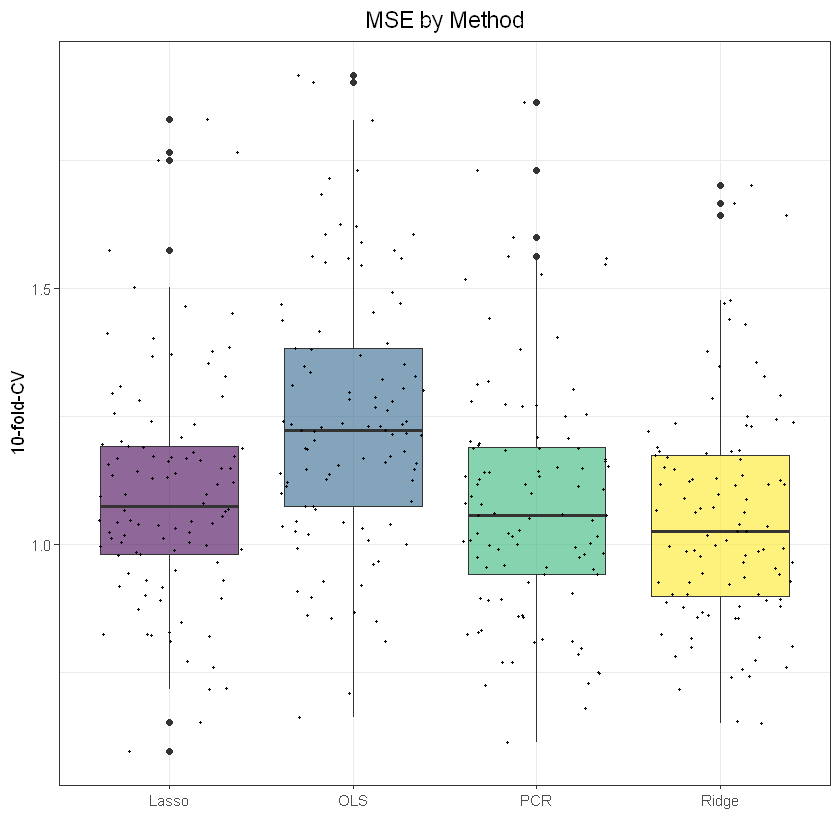

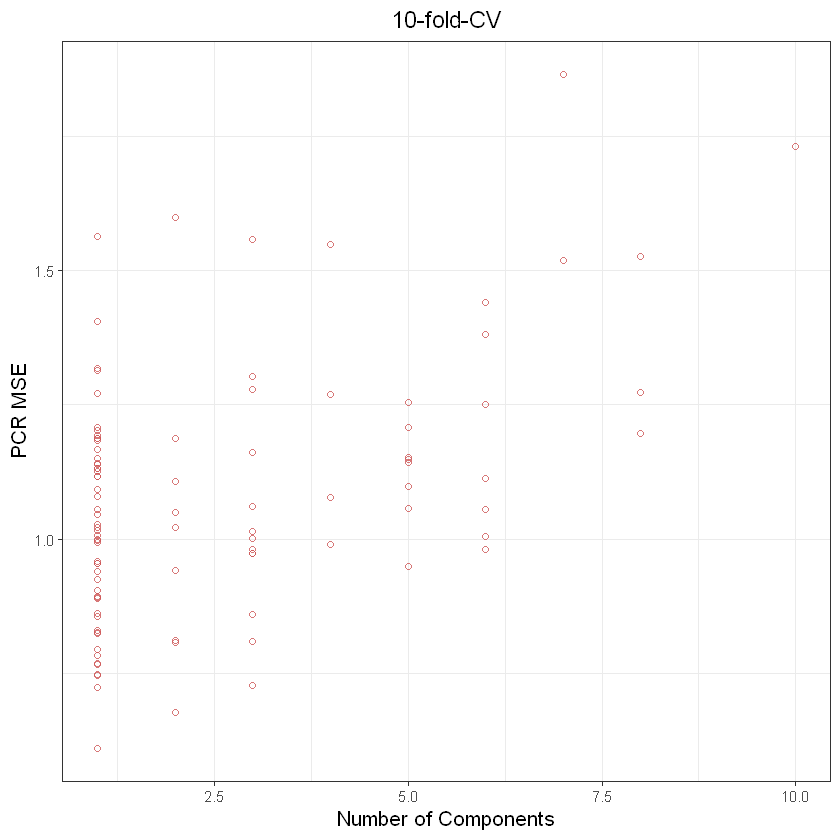

In [12]:
set.seed(123)
simfirst <- sim(N=100, Mu=c(0,10), Sigma=1, beta_grid=c(0.1,0.5), pshare=0.1, sparsity=0, reps=100, correlated = TRUE,corr_par=0.95)
simfirst

## Simulation 2

Here we almost have the same setup as in part a)

* **N = 100**                                       (observations)
* **p = 40**                                          (Regressors)
* **mu = 0**         (mean of regressors)
* **Sigma = 1**                                         (covariance matrix on-diagonals are 1 (variances))
* **beta = Randomly Uniform values from 0.1 to 0.5** 
* **Sparsity = 0**                                      (All the regressors have an influence on Y in our DGP)
* **Corr = 0**                                         (covariancnce matrix off-diagonals are 0)

$ \Large \Sigma = \begin{bmatrix} 1 & 0 & 0 & 0 & ... &0\\ 0 & 1 & 0 & 0 & ... & 0\\ 0 & 0 & 1 & 0 & ... & 0\\ 0 & 0 & 0 &1 & ... & 0\\
... & ... & ... & ... & ... & 0 \\ 0 & 0 & 0 & 0 & 0 & 1\end{bmatrix}$

$ \mu = \begin{bmatrix} 0 & 0 & ... & 0 & 0 \end{bmatrix}$

$ \beta = \begin{bmatrix} 0.1678 & 0.4879 & ... & 0.3468 & 0.4213 \end{bmatrix}$

We expect Ridge to perform better than Lasso as all predictors are relevant.

Also PCR should not perform well as there is no correlation between the predictors

$MSE_Methods

$MSE_Components

$Means
                            OLS    Ridge    Lasso      PCR Lambda_Ridge
Mean of Simulation MSE 6.550372 2.572515 3.419657 4.782533    0.5986554
                       Lambda_Lasso    M
Mean of Simulation MSE    0.1049061 37.9


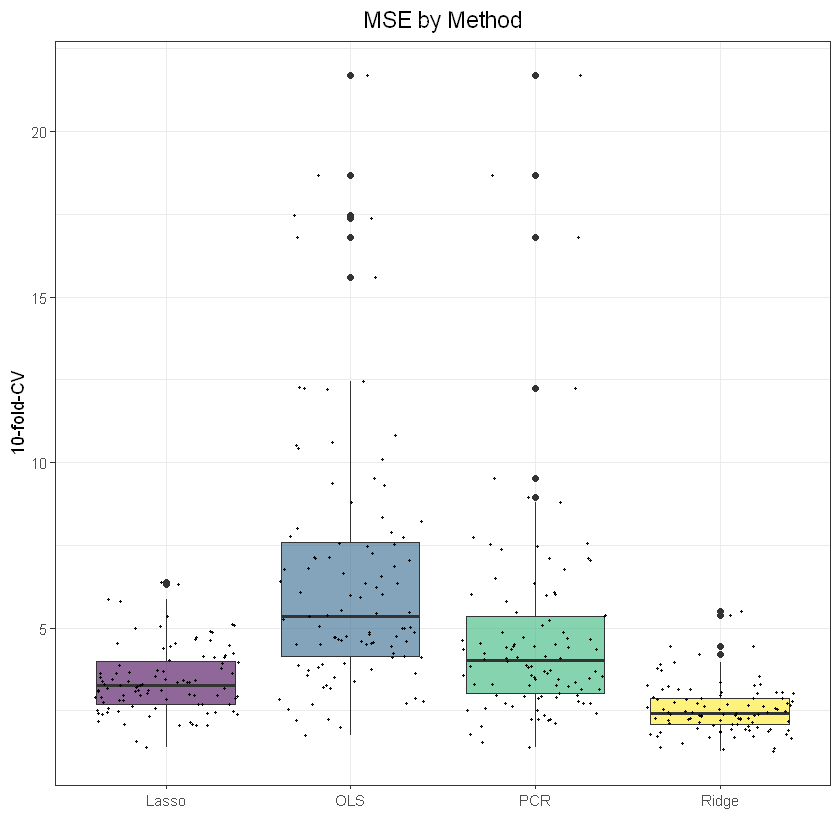

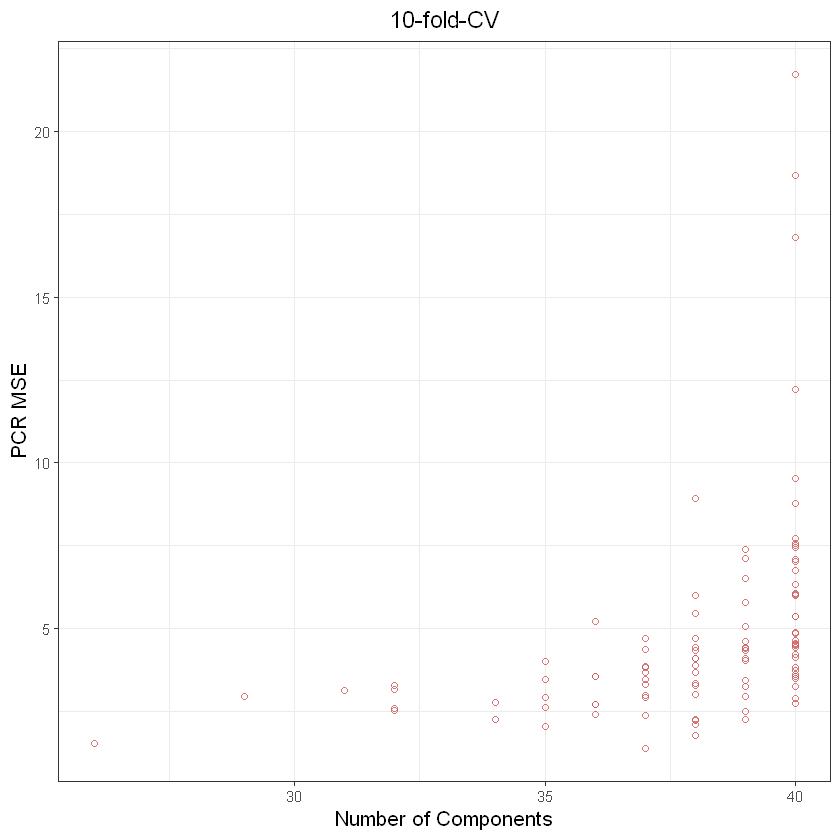

In [9]:
sim1 <- sim(N=100, Mu=c(0,0), Sigma=1, beta_grid=c(0.1,0.5), pshare=0.4, 
          sparsity=0, reps=100, correlated = FALSE, corr_par=0)

sim1

## Simulation 3

* **N = 100**                                       (observations)
* **p = 10**                                          (Regressors)
* **mu = 0**         (mean of regressors)
* **Sigma = 1**                                         (covariance matrix on-diagonals are 1 (variances))
* **beta = Randomly Uniform values from 0.1 to 0.5** 
* **Sparsity = 0**                                      (All the regressors have an influence on Y in our DGP)
* **Corr = 0**                                         (covariancnce matrix off-diagonals are 0)

$ \Large \Sigma = \begin{bmatrix} 1 & 0 & 0 & 0 & ... &0\\ 0 & 1 & 0 & 0 & ... & 0\\ 0 & 0 & 1 & 0 & ... & 0\\ 0 & 0 & 0 &1 & ... & 0\\
... & ... & ... & ... & ... & 0 \\ 0 & 0 & 0 & 0 & 0 & 1\end{bmatrix}$

$ \mu = \begin{bmatrix} 0 & 0 & ... & 0 & 0 \end{bmatrix}$

$ \beta = \begin{bmatrix} 0.1678 & 0.4879 & ... & 0.3468 & 0.4213 \end{bmatrix}$

* only change: Less predictors

$MSE_Methods

$MSE_Components

$Means
                            OLS   Ridge    Lasso      PCR Lambda_Ridge
Mean of Simulation MSE 1.279599 1.23226 1.314667 1.262779     0.346487
                       Lambda_Lasso    M
Mean of Simulation MSE   0.05408664 9.33


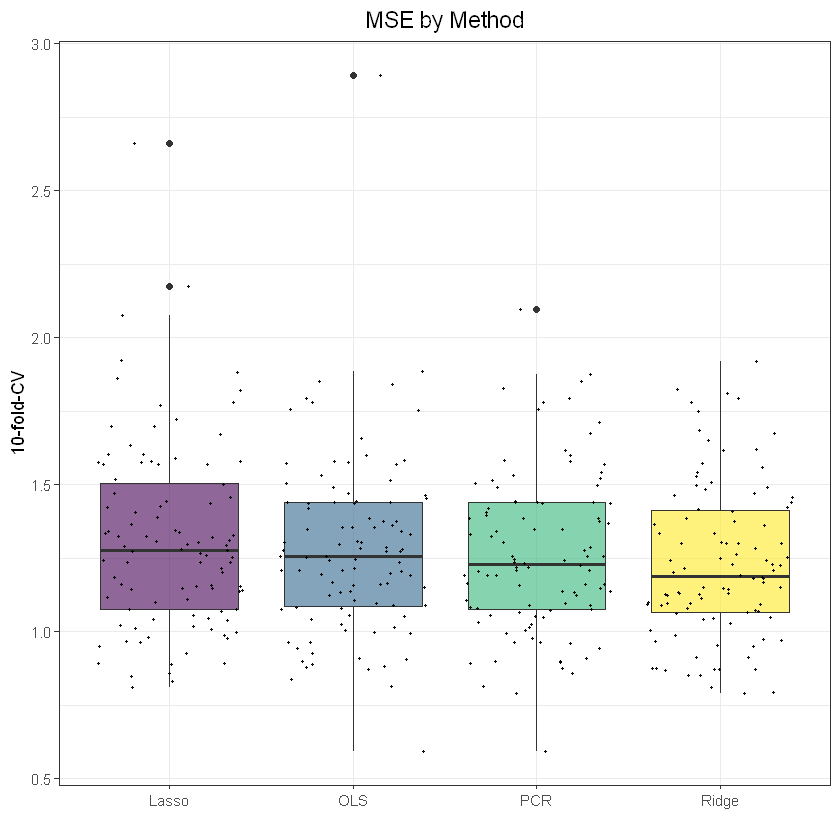

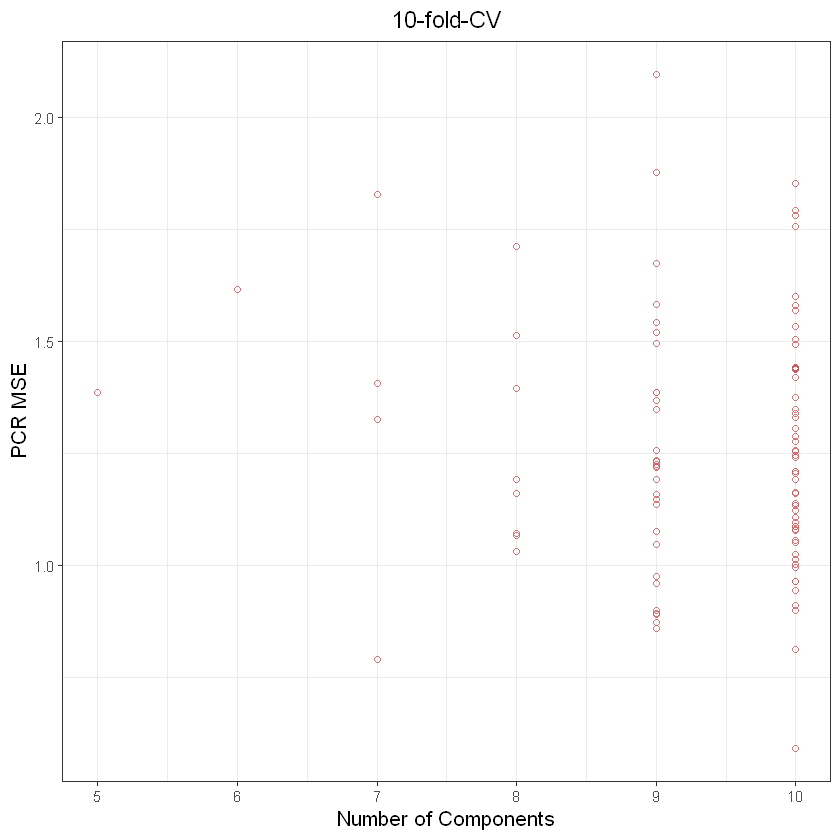

In [10]:
sim2 <- sim(N=100, Mu=c(0,0), Sigma=1, beta_grid=c(0.1,0.5), pshare=0.1, 
            sparsity=0, reps=100, correlated = FALSE, corr_par = 0)
sim2

## Simulation 4

* **N = 100**                                       (observations)
* **p = 50**                                          (Regressors)
* **mu = 0**         (mean of regressors) --> what do we have here exactly ?
* **Sigma = 1**                                         (covariance matrix on-diagonals are 1 (variances))
* **beta = Randomly Uniform values from 0.1 to 0.5** 
* **Sparsity = 0**                                      (All the regressors have an influence on Y in our DGP)
* **corr_par = 0.1**                                         (covariancnce matrix off-diagonals are 0.1)

$ \Large \Sigma = \begin{bmatrix} 1 & 0.1 & 0.1 & 0.1 & ... & 0.1\\ 0.1 & 1 & 0.1 & 0.1 & ... & 0.1\\ 0.1 & 0.1 & 1 & 0.1 & ... & 0.1\\ 0.1 & 0.1 & 0.1 & 1 & ... & 0.1\\
... & ... & ... & ... & ... & 0.1 \\ 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 1\end{bmatrix}$

$ \mu = \begin{bmatrix} 0 & 0 & ... & 0 & 0 \end{bmatrix}$

$ \beta = \begin{bmatrix} 0.1678 & 0.4879 & ... & 0.3468 & 0.4213 \end{bmatrix}$

* Only Change: low correlation between predictors

In [ ]:
sim3 <- sim(N=100, Mu=c(0,0), Sigma=1, beta_grid=c(0.1,0.5), pshare=0.5, 
            sparsity=0, reps=100, correlated = TRUE, corr_par = 0.1)

$MSE_Methods

$MSE_Components

$Means
                            OLS    Ridge    Lasso      PCR Lambda_Ridge
Mean of Simulation MSE 11716.27 8.567209 4.515249 2.360988     26.90946
                       Lambda_Lasso     M
Mean of Simulation MSE   0.05044508 23.63


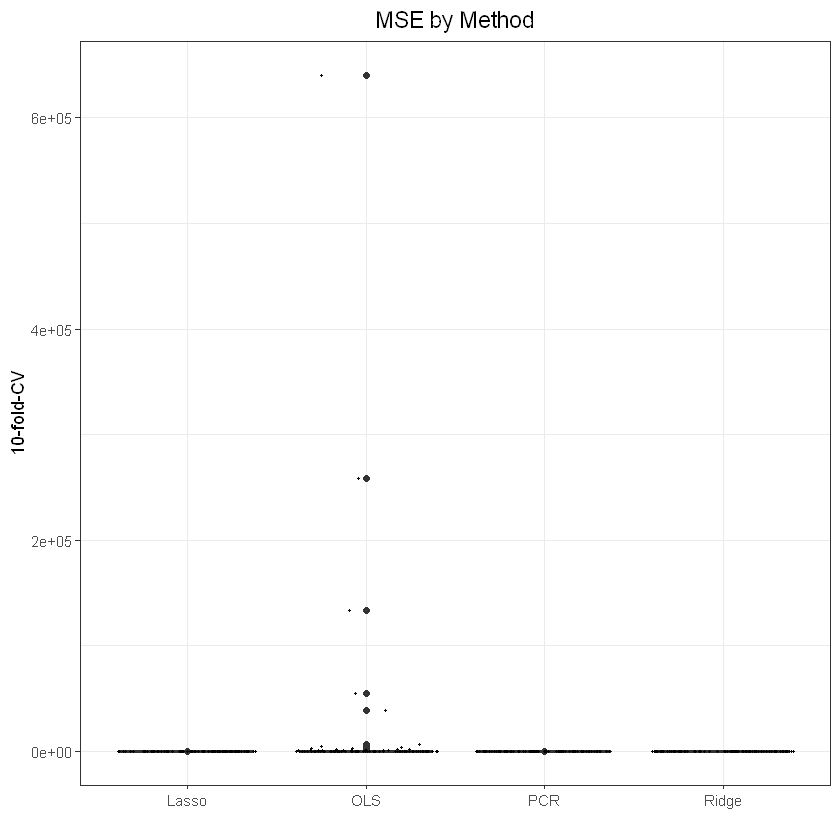

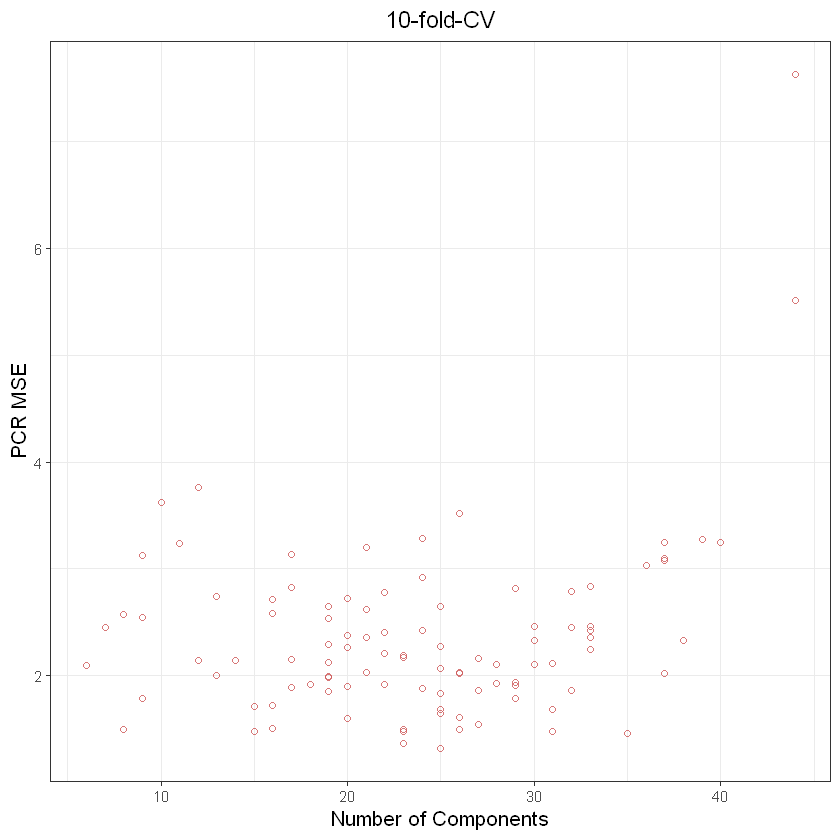

In [61]:
sim3

## Simulation 5

* slight sparsity: only 80% of predictors are relevant
* still all non zero-beta predictors are highly correlated

Well expect Lasso to perform better than Ridge as only 80% of the covariates really predict Y in the dgp.
Lasso shrinks estimates which are close to zero to exactly 0 while Ridge uses all parameters in the prediction

Still there is a lot of correlation between the predictors so PCA should also perform well

In [ ]:
sim6 <- sim(N=100, Mu=c(0,0), Sigma=1, beta_grid=c(0.1,0.5), pshare=0.5, 
            sparsity=0.2, reps=100, correlated = TRUE, corr_par = 0.95)

$MSE_Methods

$MSE_Components

$Means
                            OLS    Ridge    Lasso      PCR Lambda_Ridge
Mean of Simulation MSE 6649.058 5.136717 1.845397 1.437063     80.29405
                       Lambda_Lasso     M
Mean of Simulation MSE    0.1042128 13.23


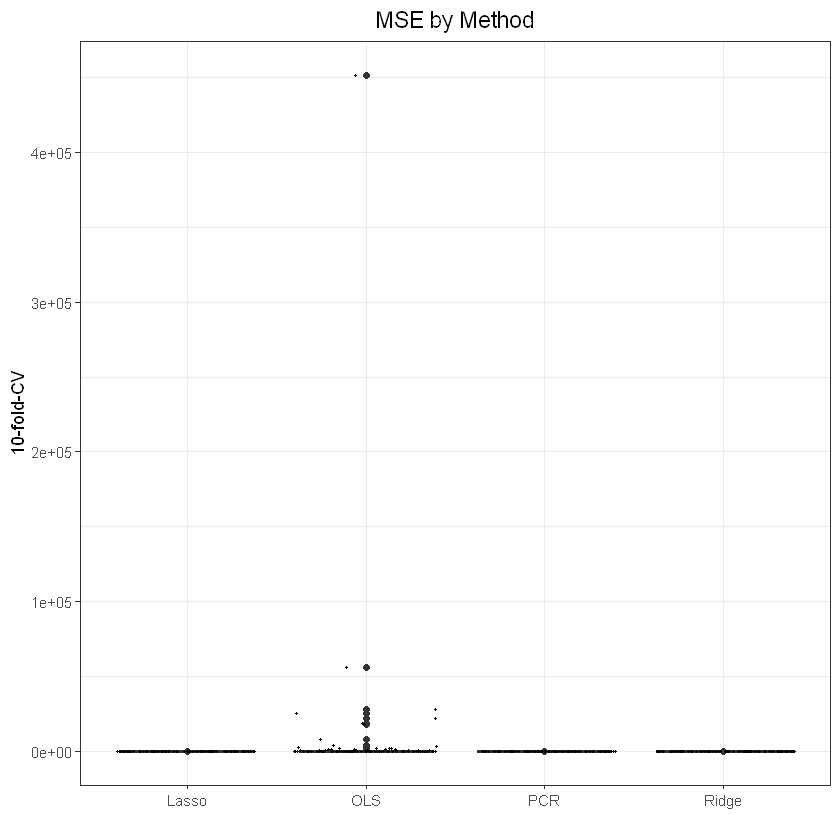

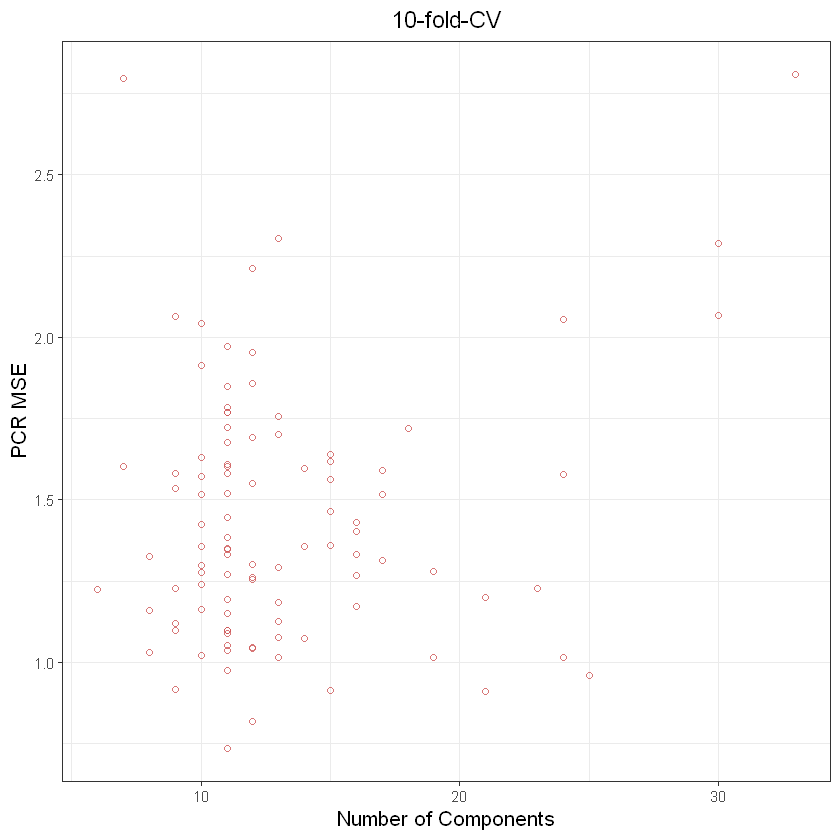

In [57]:
sim6

## Simulation 6
* same as previous : now all mus are randomly drawn from interval between 0 and 10

In [ ]:
sim7 <- sim(N=100, Mu=c(0,10), Sigma=1, beta_grid=c(0.1,0.5), pshare=0.5, 
            sparsity=0.2, reps=100, correlated = TRUE, corr_par = 0.95)

$MSE_Methods

$MSE_Components

$Means
                            OLS   Ridge    Lasso      PCR Lambda_Ridge
Mean of Simulation MSE 2705.289 4.92851 1.835707 1.471595     79.98476
                       Lambda_Lasso     M
Mean of Simulation MSE      0.10092 11.49


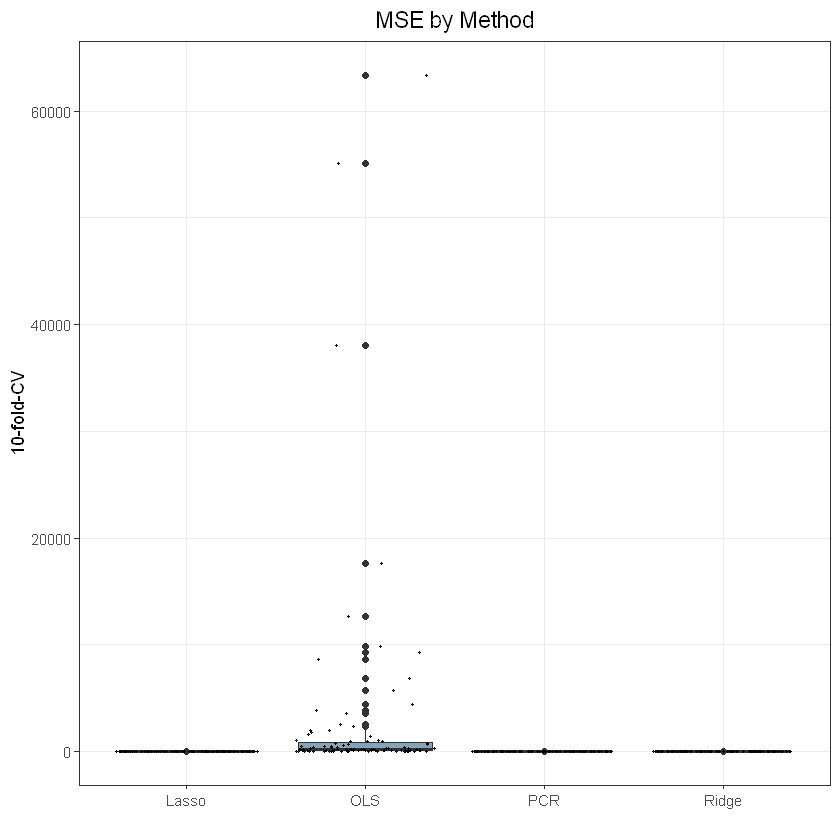

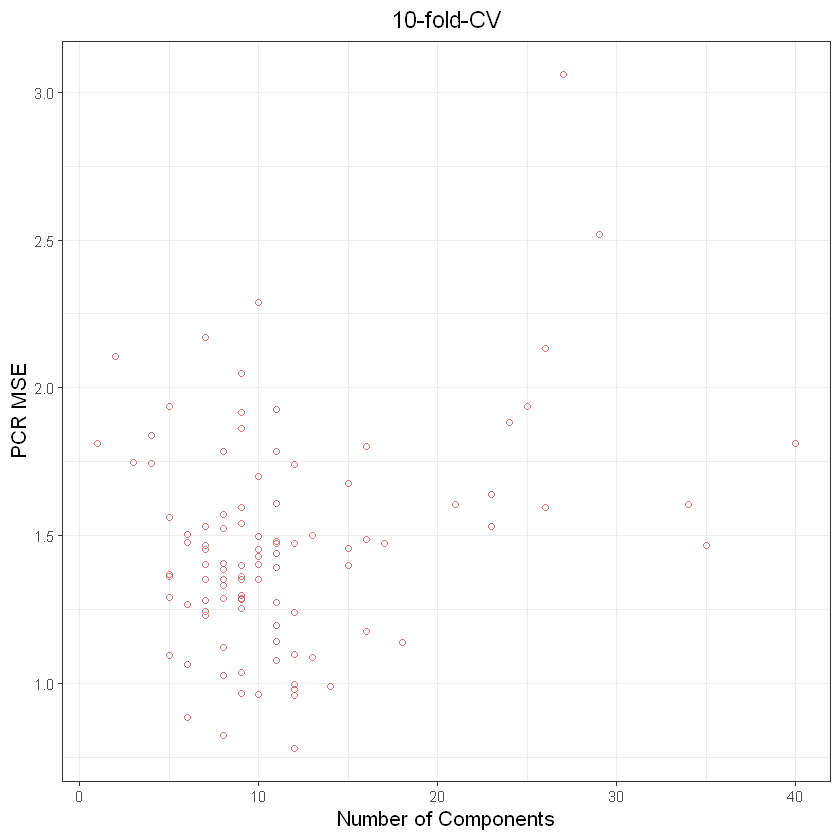

In [58]:
sim7

## Simulation 7

* 10 predictors
* only 5 of those are relevant and highly correlated with each other

$MSE_Methods

$MSE_Components

$Means
                            OLS    Ridge    Lasso      PCR Lambda_Ridge
Mean of Simulation MSE 1.258476 1.109596 1.132101 1.160416    0.8366551
                       Lambda_Lasso    M
Mean of Simulation MSE    0.0948099 4.39


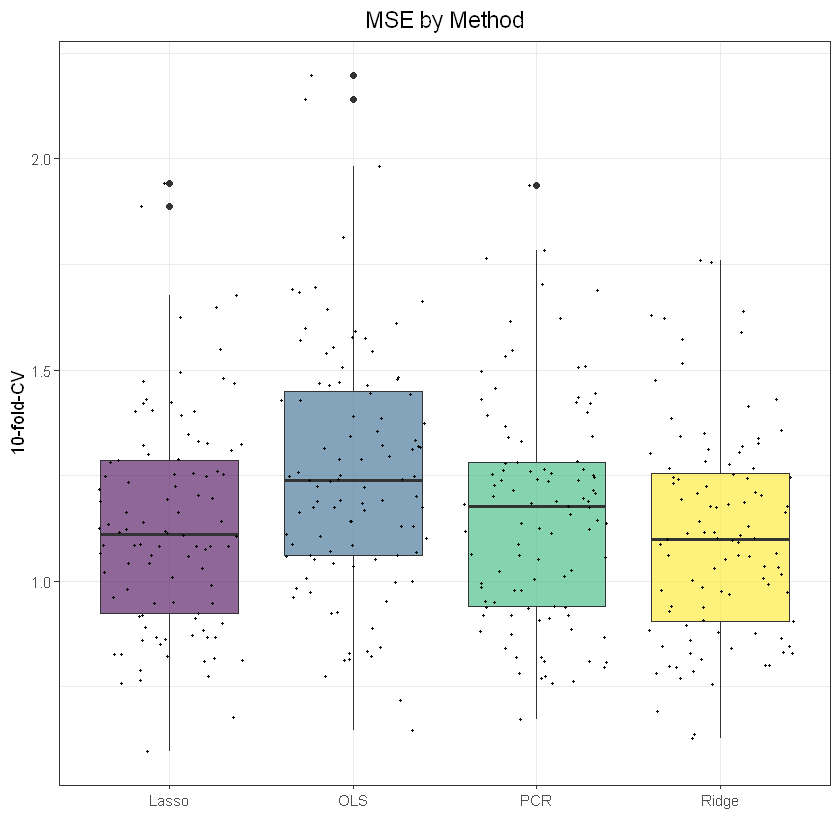

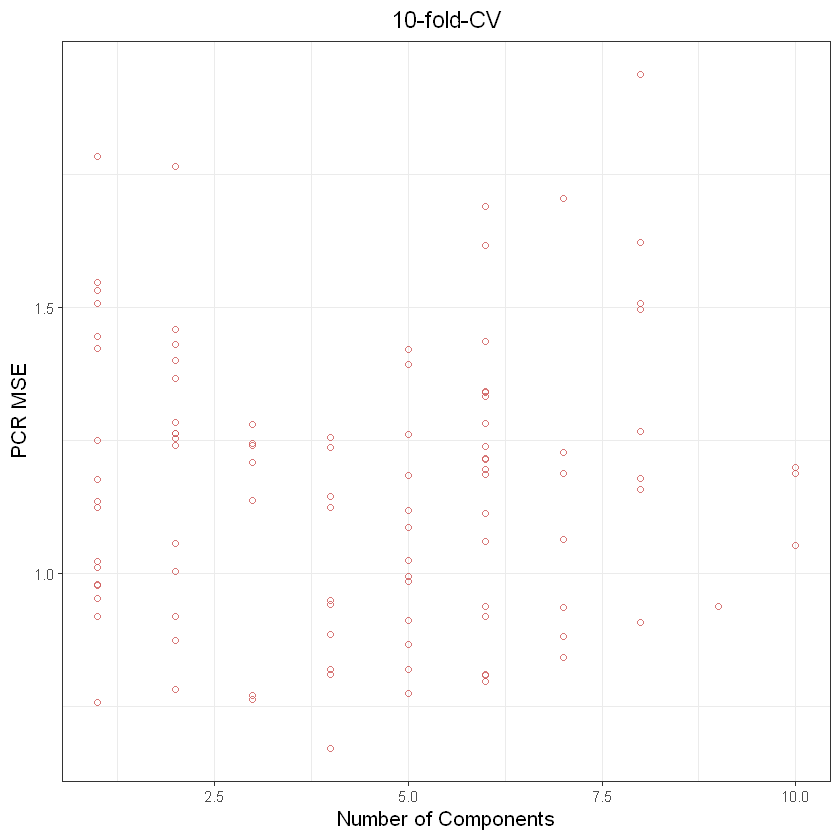

In [9]:
sim9 <- sim(N=100, Mu=c(0,2), Sigma=1, beta_grid=c(0.1,0.5), pshare=0.1, 
            sparsity=0.5, reps=100, correlated = TRUE, corr_par = 0.95)
sim9

## Simulation 8

* p: 50
* sparsity: 25 betas are set to zero
* correlation is set to 0.5

-> expect Lasso to perform better than Ridge compared to the last simulation

In [ ]:
sim10 <- sim(N=100, Mu=c(0,5), Sigma=1, beta_grid=c(0.1,0.5), pshare=0.5, 
            sparsity=0.5, reps=100, correlated = TRUE, corr_par = 0.5)

$MSE_Methods

$MSE_Components

$Means
                            OLS    Ridge    Lasso      PCR Lambda_Ridge
Mean of Simulation MSE 1313.766 3.402587 2.483775 2.382919     21.31547
                       Lambda_Lasso     M
Mean of Simulation MSE    0.1072477 24.04


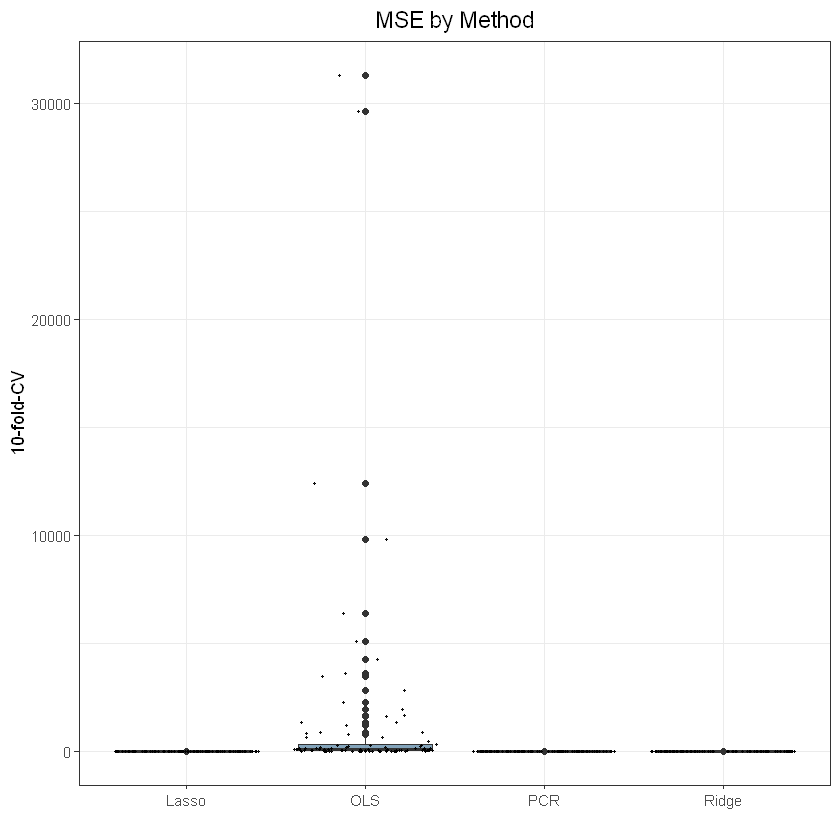

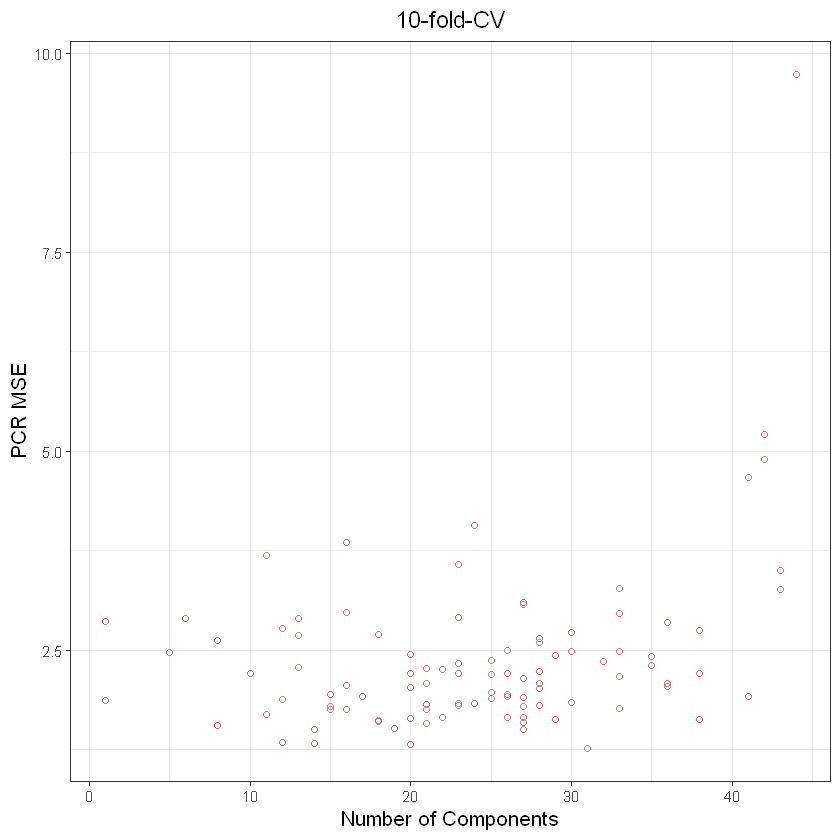

In [60]:
sim10